In [27]:
import json
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU
from sklearn.multioutput import MultiOutputClassifier
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow
from math import sqrt
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
df_business = pd.read_csv(r"C:\Users\iontel\Desktop\OneDrive - Danmarks Tekniske Universitet\CS Master\2020 Spring\42578 Advanced Business Analytics\final proj\data\yelp_dataset\toronto_all_business.csv")
df_checkin = pd.read_csv(r"C:\Users\iontel\Desktop\OneDrive - Danmarks Tekniske Universitet\CS Master\2020 Spring\42578 Advanced Business Analytics\final proj\data\yelp_dataset\toronto_all_checkins.csv")
df_review = pd.read_csv(r"C:\Users\iontel\Desktop\OneDrive - Danmarks Tekniske Universitet\CS Master\2020 Spring\42578 Advanced Business Analytics\final proj\data\yelp_dataset\toronto_all_reviews.csv")
df_tip = pd.read_csv(r"C:\Users\iontel\Desktop\OneDrive - Danmarks Tekniske Universitet\CS Master\2020 Spring\42578 Advanced Business Analytics\final proj\data\yelp_dataset\toronto_all_tips.csv")
df_user = pd.read_csv(r"C:\Users\iontel\Desktop\OneDrive - Danmarks Tekniske Universitet\CS Master\2020 Spring\42578 Advanced Business Analytics\final proj\data\yelp_dataset\toronto_all_users.csv")


C:\Users\iontel\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_business_toronto = df_business[df_business['city']=='Toronto']

In [4]:
KNN_df_x = pd.read_csv('KNN distance train.csv')
KNN_df_x.replace(0, 5)
KNN_df_x.stars = 10*KNN_df_x.stars
KNN_df_x['1stars'] = 10*KNN_df_x['1stars']
KNN_df_x['2stars'] = 10*KNN_df_x['2stars']
KNN_df_x['3stars'] = 10*KNN_df_x['3stars']
KNN_df_x['4stars'] = 10*KNN_df_x['4stars']
KNN_df_x['5stars'] = 10*KNN_df_x['5stars']
KNN_df_x.replace(0,1,inplace=True)
KNN_df_x['1nearest_dist'] = KNN_df_x['1nearest_dist'].astype(int)
KNN_df_x['2nearest_dist'] = KNN_df_x['2nearest_dist'].astype(int)
KNN_df_x['3nearest_dist'] = KNN_df_x['3nearest_dist'].astype(int)
KNN_df_x['4nearest_dist'] = KNN_df_x['4nearest_dist'].astype(int)
KNN_df_x['5nearest_dist'] = KNN_df_x['5nearest_dist'].astype(int)
KNN_df_x=KNN_df_x.drop(columns=['distances','nearest'])
KNN_df_x.dropna()
KNN_df_x

,Unnamed: 0,latitude,longitude,stars,latlon,1nearest_dist,1stars,2nearest_dist,2stars,3nearest_dist,3stars,4nearest_dist,4stars,5nearest_dist,5stars
0,3,43.633293,-79.531770,30.0,"(43.63329315185547, -79.53176879882812)",1,40.0,44,30.0,44,30.0,58,25.0,742,30.0
1,5,43.666378,-79.348770,40.0,"(43.666378021240234, -79.34877014160156)",64,50.0,81,50.0,84,40.0,105,40.0,119,40.0
2,11,43.649860,-79.382060,30.0,"(43.64986038208008, -79.3820571899414)",64,40.0,66,40.0,72,35.0,72,35.0,90,35.0
3,14,43.765278,-79.326250,30.0,"(43.76527786254883, -79.32624816894531)",511,25.0,538,35.0,733,35.0,739,40.0,740,35.0
4,15,43.685608,-79.313934,45.0,"(43.68560791015625, -79.31393432617188)",8,40.0,57,30.0,65,35.0,78,40.0,78,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8674,20318,43.700615,-79.396760,40.0,"(43.70061492919922, -79.39675903320312)",9,35.0,11,40.0,18,35.0,18,50.0,41,40.0
8675,20320,43.726658,-79.480360,35.0,"(43.72665786743164, -79.48036193847656)",29,25.0,33,30.0,145,40.0,169,10.0,169,40.0
8676,20321,43.657715,-79.402100,40.0,"(43.65771484375, -79.402099609375)",21,35.0,23,40.0,24,35.0,31,35.0,32,40.0
8677,20325,43.701810,-79.575134,40.0,"(43.70180892944336, -79.57513427734375)",990,25.0,1058,25.0,1136,30.0,1163,20.0,1166,20.0


In [5]:
class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        m1, m2 = 'loss', 'val_loss'
        #
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get(m1))
        self.val_losses.append(logs.get(m2))
        self.i += 1
        #
        clear_output(wait=True)
        #
        fig = plt.figure(figsize=(6, 4))
        plt.plot(self.x, self.losses, label='train')
        plt.plot(self.x, self.val_losses, label='validation', ls='--')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.yscale('log')
        plt.legend()
        plt.show()
        
plot_learning = PlotLosses()

In [6]:
KNN_df_x1=KNN_df_x
KNN_df_x = KNN_df_x.filter(['latitude','longitude','stars','1nearest_dist','1stars','2nearest_dist','2stars','3nearest_dist','3stars','4nearest_dist','4stars','5nearest_dist','5stars'], axis=1)
KNN_df_y = KNN_df_x1.filter(['stars'], axis=1)

In [7]:
target_col = "stars"
    # features
feature_cols = [
         # the target column is included to make the model autoregressive
'stars','latitude', 'longitude','1nearest_dist','1stars','2nearest_dist','2stars','3nearest_dist','3stars','4nearest_dist','4stars','5nearest_dist','5stars'
    ]

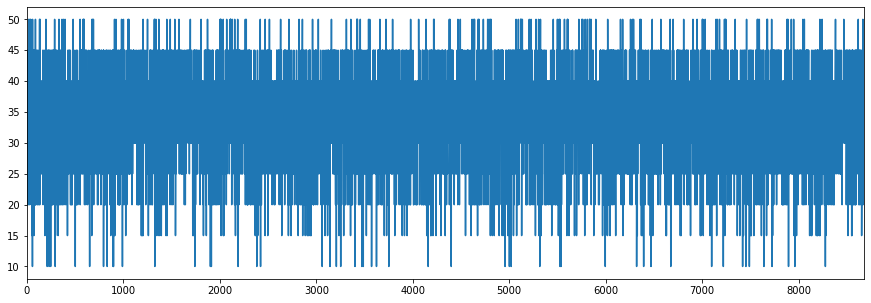

In [8]:
FIGSIZE = (15, 5)
KNN_df_x[target_col].plot(figsize=FIGSIZE)
plt.show()

In [9]:
lag_window =  20
prediction_window = 20

In [10]:
KNN_df_x

,latitude,longitude,stars,1nearest_dist,1stars,2nearest_dist,2stars,3nearest_dist,3stars,4nearest_dist,4stars,5nearest_dist,5stars
0,43.633293,-79.531770,30.0,1,40.0,44,30.0,44,30.0,58,25.0,742,30.0
1,43.666378,-79.348770,40.0,64,50.0,81,50.0,84,40.0,105,40.0,119,40.0
2,43.649860,-79.382060,30.0,64,40.0,66,40.0,72,35.0,72,35.0,90,35.0
3,43.765278,-79.326250,30.0,511,25.0,538,35.0,733,35.0,739,40.0,740,35.0
4,43.685608,-79.313934,45.0,8,40.0,57,30.0,65,35.0,78,40.0,78,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8674,43.700615,-79.396760,40.0,9,35.0,11,40.0,18,35.0,18,50.0,41,40.0
8675,43.726658,-79.480360,35.0,29,25.0,33,30.0,145,40.0,169,10.0,169,40.0
8676,43.657715,-79.402100,40.0,21,35.0,23,40.0,24,35.0,31,35.0,32,40.0
8677,43.701810,-79.575134,40.0,990,25.0,1058,25.0,1136,30.0,1163,20.0,1166,20.0


In [11]:
#Restaurant = df_business_toronto[df_business_toronto['categories'].str.contains('Restaurants')]
#Restaurant=Restaurant.drop(columns=['name','address','business_id','stars','city','state','postal_code','review_count','is_open','attributes','categories','hours'])

#Restaurant =Restaurant.join(KNN_df_x['stars'])
#Restaurant =Restaurant.join(KNN_df_x['1nearest_dist'])
#Restaurant =Restaurant.join(KNN_df_x['1stars'])
#Restaurant =Restaurant.join(KNN_df_x['2nearest_dist'])
#Restaurant =Restaurant.join(KNN_df_x['2stars'])
#Restaurant =Restaurant.join(KNN_df_x['3nearest_dist'])
#Restaurant =Restaurant.join(KNN_df_x['3stars'])
#Restaurant =Restaurant.join(KNN_df_x['4nearest_dist'])
#Restaurant =Restaurant.join(KNN_df_x['4stars'])
#Restaurant =Restaurant.join(KNN_df_x['5nearest_dist'])
#Restaurant =Restaurant.join(KNN_df_x['5stars'])

#Restaurant

In [12]:
def prepare_data(KNN_df_x, target_col, feature_cols, lag_window, prediction_window):
    """A helper function for preparing datasets for modeling.
    It splits the data into a list of rolling windows,
    where the first seq_len values are to be used as features
    and the next value as a target variable.
    
     Args:
        df (pandas.DataFrame): Pandas DataFrame with data.
        target_col (str): Target column.
        lag_window (int): Rolling window size 
            (Number of historical values to use in modeling).
        
    Returns:
        tuple: (X, y, dates).
            
    """
    # split the data into rolling windows
    X, y, num = [], [], []
    for index in range(len(KNN_df_x) - lag_window - 1 - prediction_window):
        # target values
        y.append(KNN_df_x[target_col][index + lag_window: 
                                index + lag_window + prediction_window])
        X_c = []
        # make sure that the lagged values are in the first feature
        if target_col in feature_cols:
            X_c.append(KNN_df_x[target_col][index: index + lag_window])
        for col_name in feature_cols:
            if col_name == target_col:
                continue
            X_c.append(KNN_df_x[col_name][index: index + lag_window])
        num.append(KNN_df_x.index[index + lag_window])

        X.append(X_c)
    return X, y, num
#X, y, num = np.array(X), np.array(y), np.array([num])


In [13]:
X, y, num = prepare_data(KNN_df_x, target_col, feature_cols, lag_window, prediction_window)

In [14]:
X = np.array(X)
y = np.array(y)
num = np.array(num)

In [15]:
X_shape = X.shape
X_shape

(8638, 13, 20)

In [16]:
Y_shape = y.shape
Y_shape


(8638, 20)

In [17]:
X = X.reshape((X_shape[0], X_shape[1] * X_shape[2]))
X.shape

(8638, 260)

In [18]:
train_size=0.8 # first 80% of data will be used for train, the rest 20% for test
indices = np.arange(X_shape[0])
indices_train, indices_test = train_test_split(indices, 
                                               train_size=train_size, shuffle=False)
X_train, X_test, y_train, y_test = X[indices_train], X[indices_test], \
                                   y[indices_train], y[indices_test]
num_train, num_test = num[indices_train], num[indices_test]
print(y)

[[30. 40. 30. ... 30. 35. 50.]
 [40. 30. 30. ... 35. 50. 35.]
 [30. 30. 40. ... 50. 35. 40.]
 ...
 [20. 35. 40. ... 30. 40. 40.]
 [35. 40. 30. ... 40. 40. 35.]
 [40. 30. 35. ... 40. 35. 40.]]


#### nornmalization

In [19]:
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

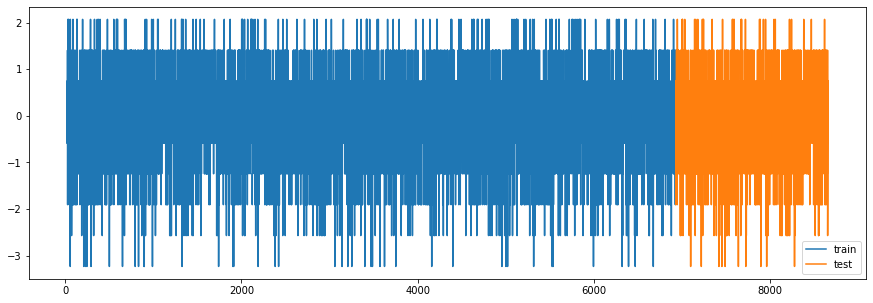

In [20]:
plt.figure(figsize=FIGSIZE)
plt.plot(num_train, y_train[:, 0], label="train")
plt.plot(num_test, y_test[:, 0], label="test")
plt.legend()
plt.show()

#### Run with RNN

In [21]:
X_train_rnn = np.transpose(X_train.reshape((-1, X_shape[1], X_shape[2])), (0, 2, 1))
X_test_rnn = np.transpose(X_test.reshape((-1, X_shape[1], X_shape[2])), (0, 2, 1))
# [n_samples, n_timestamps, n_features]
X_train_rnn.shape

(6910, 20, 13)

In [22]:
def get_rnn_model_keras(input_shape, output_size, cell_type):
    """RNN model"""
    params = {}
    if cell_type=='SimpleRNN':
        cell_type_func = SimpleRNN
        params['activation'] = 'tanh'
    elif cell_type=='LSTM':
        cell_type_func = LSTM
        params['recurrent_activation'] = 'sigmoid'
    elif cell_type=='GRU':
        cell_type_func = GRU
    else:
        raise Exception("Unknown cell_type")
    #
    model = Sequential()
    # simple one-layer RNN
    model.add(cell_type_func(100, input_shape=input_shape, **params))
    # for a multi-layer stacked RNN, all but last layer 
    # should have "return_sequences=True"
    # https://keras.io/getting-started/sequential-model-guide/#stacked-lstm-for-sequence-classification
    # for example
    #model.add(cell_type_func(32, input_shape=input_shape, return_sequences=True, **params))
    #model.add(cell_type_func(32, return_sequences=True, **params))
    #model.add(cell_type_func(32, **params))
    model.add(Dense(output_size))
    model.compile(loss='mse', optimizer='RMSprop', metrics=['mse'])
    #
    print(model.summary())
    return model

In [23]:
rnn_model_keras = get_rnn_model_keras(X_train_rnn.shape[1:], y_train.shape[1], 'SimpleRNN')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 100)               11400     
_________________________________________________________________
dense (Dense)                (None, 20)                2020      
Total params: 13,420
Trainable params: 13,420
Non-trainable params: 0
_________________________________________________________________
None


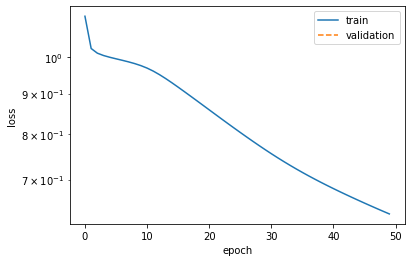

In [24]:
batch_size = 128
epochs = 50

history = rnn_model_keras.fit(X_train_rnn, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    shuffle=False,
                    callbacks=[plot_learning], # plot learning progress
                    #validation_data=(X_test_rnn, y_test_rnn), 
                    # it's a sort of cheating to validate the error on the test set
                   )

In [25]:
y_pred = rnn_model_keras.predict(X_test_rnn)

In [30]:
def analyze_results(y_true, y_pred, dates, horizon):
    """Plots the prediction for a given prediction horizon.
    If horizon>1 than it plots the prediction values after the current
    horizon, so the predictions do not overlap.
    RMSE is calculated for all the predicted values within the horizon."""
    print("Horizon:", horizon)
    y_true_plot = y_true[::horizon, :horizon].ravel()[:len(dates)]
    y_pred_plot = y_pred[::horizon, :horizon].ravel()[:len(dates)]
    plt.figure(figsize=FIGSIZE)
    plt.plot(dates[:len(y_true_plot)], y_true_plot, label='True Data') 
    plt.plot(dates[:len(y_true_plot)], y_pred_plot, label='Prediction') 
    plt.legend() 
    plt.show()
    #
    RMSE = np.sqrt(mean_squared_error(y_true[:, :horizon], y_pred[:, :horizon]))
    print("RMSE:", RMSE)

Horizon: 1


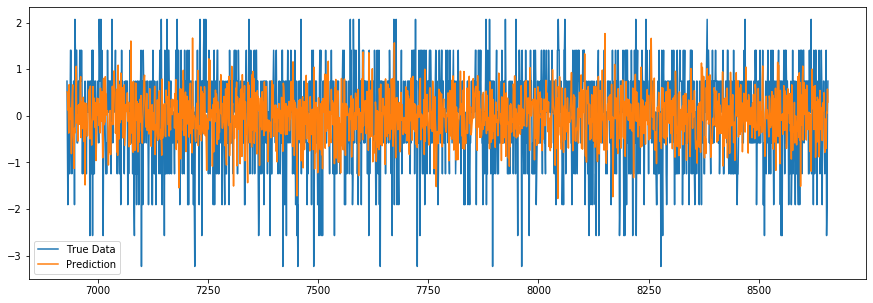

RMSE: 1.114255555928492


In [32]:
analyze_results(y_test, y_pred, num_test, 1)

In [33]:
analyze_results(y_test, y_pred, dates_test, prediction_window)

NameError: name 'dates_test' is not defined